## Requirements

In [1]:
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd
import time

## Using numba

Consider the following dataframe with 2 million rows.

In [2]:
size = 2_000_000
df = pd.DataFrame({
    'x': np.random.rand(size),
    'y': np.random.rand(size),
})

You want to create a series computed as $\sqrt{x^2 + y^2}$.  You can consider three approoaches:
1. pandas' `.apply()` method,
2. numpy expressions, and
3. using a numba function.

In [12]:
%time df.apply(lambda row: np.sqrt(row['x']**2 + row['y']**2), axis=1);

CPU times: user 8.93 s, sys: 288 ms, total: 9.22 s
Wall time: 9.22 s


In [13]:
%time np.sqrt(df['x']**2 + df['y']**2);

CPU times: user 34.4 ms, sys: 16.1 ms, total: 50.5 ms
Wall time: 48.9 ms


It is clear that the using numpy is much more efficient, the speedup is 250.

In [15]:
@njit
def score_numba(x, y):
    result = np.empty_like(x)
    for i in range(len(x)):
        result[i] = np.sqrt(x[i]**2 + y[i]**2)
    return result

In [6]:
%time score_numba(df.x.values, df.y.values);

CPU times: user 248 ms, sys: 47.8 ms, total: 296 ms
Wall time: 433 ms


Using numba is about 25 times faster than the pandas `.apply()` method, but 10 slower than numpy, so is there a point?

There is if you run that function multiple times.

In [7]:
%time score_numba(df.x.values, df.y.values);

CPU times: user 5.7 ms, sys: 0 ns, total: 5.7 ms
Wall time: 5.77 ms


As you can see, numba is now more than 2,000 times faster then the equivalent `.apply()` method call.  Once the initial compilation has been done, there is little or no overhead on subsequent calls.

This can be compared to a similar implementation with a non-compiled Python function.

In [8]:
def score_python(x, y):
    result = np.empty_like(x)
    for i in range(len(x)):
        result[i] = np.sqrt(x[i]**2 + y[i]**2)
    return result

In [9]:
%time score_python(df.x.values, df.y.values);

CPU times: user 1.74 s, sys: 0 ns, total: 1.74 s
Wall time: 1.74 s


Even this approach is faster than pandas' `.apply()`, but still more than 200 times slower than numba (once compiled).

## Benchmark

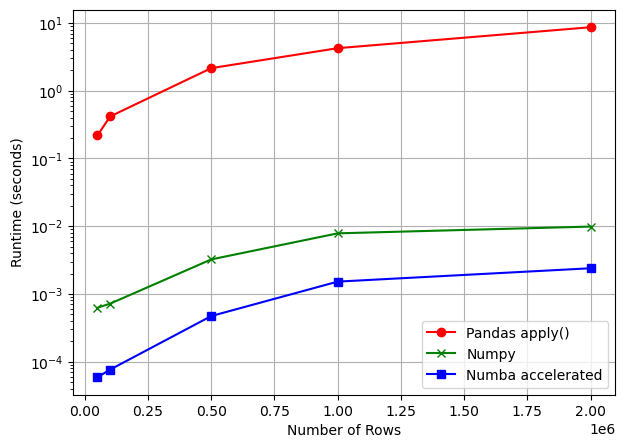

In [17]:
sizes = [50_000, 100_000, 500_000, 1_000_000, 2_000_000]
times_apply, times_numpy, times_numba = [], [], []

for size in sizes:
    df = pd.DataFrame({
        "x": np.random.rand(size),
        "y": np.random.rand(size)
    })
    
    start = time.time()
    df.apply(lambda row: np.sqrt(row['x']**2 + row['y']**2), axis=1)
    times_apply.append(time.time() - start)
    
    start = time.time()
    np.sqrt(df['x']**2 + df['y']**2)
    times_numpy.append(time.time() - start)
    
    score_numba(df['x'].values, df['y'].values)  # warm-up compile
    start = time.time()
    score_numba(df['x'].values, df['y'].values)
    times_numba.append(time.time() - start)

plt.figure(figsize=(7,5))
plt.plot(sizes, times_apply, "o-r", label="Pandas apply()")
plt.plot(sizes, times_numpy, "x-g", label="Numpy")
plt.plot(sizes, times_numba, "s-b", label="Numba accelerated")
plt.xlabel("Number of Rows")
plt.ylabel("Runtime (seconds)")
plt.yscale('log')
plt.legend()
plt.grid(True)

It is clear that numba can significantly speedup computations that rely on function that are called repeatedly.